# Demo1: Flight Delay Prediction

In this notebook we use the [Flights Dataset](http://stat-computing.org/dataexpo/2009/the-data.html) dataset to analyze and predict flight delays in airports based on past flight records. 

For this dataset, we will only look at the flights in 2008.

In this notebook, we will build **a classification model to predict airline delay from historical flight data.**  



As usual, we first import some Python packages that we need:

In [4]:
# For SQL-type queries (Spark)
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import udf

# For regression and other possible ML tools (Spark)
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics

# Important for managing features  (Spark)
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler

# For displaying and other related IPython tools...
from IPython.display import display
#from IPython.html.widgets import in
from ipywidgets import interact

# Typycal Python tools
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path

# To show plots inline
%matplotlib inline

### Import data
To import data into your Data Scientist Workbench (DSWB), you can take either one of these actions:

1) Paste the following link into the sidebar of your DSWB:
https://share.datascientistworkbench.com/#/api/v1/workbench/10.115.89.160/shares/QBNwgXam7veFKl7/airline2007.csv

OR

2) Run the following cell to download it directly to you DSWB.

In [2]:
#Will download airline2008.csv if file not yet downloaded

if os.path.isfile("/resources/airline2008.csv") != True:
    #If file does not already exist, download it, unzip, then delete zipped file
    !wget --quiet --output-document  /resources/airline2008.csv.bz2 http://stat-computing.org/dataexpo/2009/2007.csv.bz2
    !bzip2 -d /resources/airline2008.csv.bz2
    !rm /resources/airline2008.csv.bz2
    print "Downloaded to /resources/airline2008.csv"
else:
    #If file already exists
    print "airline2008.csv already exists under /resources/airline2008.csv"
    print "You can continue to the next cell."

airline2008.csv already exists under /resources/airline2008.csv
You can continue to the next cell.


In [6]:
from pyspark import SparkContext
sc =SparkContext()
textFile = sc.textFile('2008.csv')

### Cleaning and exploration
In this section, we remove the header of file, get the number of records in the dataset and take a look what the data look like and the number of features we have access to.

In [8]:
textFileRDD = textFile.map(lambda x: x.split(','))
header = textFileRDD.first()

textRDD = textFileRDD.filter(lambda r: r != header)

In [10]:
num_records = textFileRDD.count()
print ('Number of records ' , num_records)

Number of records  7009729


In [11]:
aux_ = textFileRDD.take(2)
feature_names = aux_[0]
feature_example = aux_[1]

In [15]:
print ("Features names")
print (feature_names)

Features names
['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']


In [16]:
print ("Feature example")
print (feature_example)

Feature example
['2008', '1', '3', '4', '2003', '1955', '2211', '2225', 'WN', '335', 'N712SW', '128', '150', '116', '-14', '8', 'IAD', 'TPA', '810', '4', '8', '0', '', '0', 'NA', 'NA', 'NA', 'NA', 'NA']


In [18]:
print ("Number of features = " , len(feature_example))

Number of features =  29


### Creating a SQL Dataframe from RDD

We now create a SQL DataFrame, this entity is a distributed collection of data organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in Python, but with richer optimizations under the hood. We will utilize the recently created Spark RDD and use the Spark SQL context to create the desired data frame,

We first create function that will allow to parse a record of our RDD into the desired format. As a reference we take a look at features_names and feature_example we just created above

In [19]:
def parse(x):
    try:
        y=Row(Year=int(x[0]),\
          Month=int(x[1]),\
          DayofMonth=int(x[2]),\
          DayOfWeek=int(x[3]),\
          DepTime=int(float(x[4])), \
          CRSDepTime=int(x[5]),\
          ArrTime=int(float(x[6])),\
          CRSArrTime=int(x[7]), \
          UniqueCarrier=x[8],\
          DepDelay=int(float(x[15])),\
          Origin=x[16],\
          Dest=x[17], \
          Distance=int(float(x[18])))  
    except:
        y=None  
    return y

We now apply the previous function to our RDD and use it to create the SQL dataframe.

In [26]:
from pyspark import SparkContext
import pyspark.sql 
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

rowRDD = textRDD.map(lambda x: parse(x)).filter(lambda x: x != None)
df = sqlContext.createDataFrame(rowRDD)

We add a new column to our data frame, **DepDelayed**, a binary variable:
- **True**, for flights that have > 15 minutes of delay
- **False**, for flights that have <= 15 minutes of delay

We will later use **Depdelayed** as the target/label column in the classification process.

In [27]:
df = df.withColumn('DepDelayed', df['DepDelay']>15)

In [28]:
df.take(5)

[Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, DepTime=2003, CRSDepTime=1955, ArrTime=2211, CRSArrTime=2225, UniqueCarrier='WN', DepDelay=8, Origin='IAD', Dest='TPA', Distance=810, DepDelayed=False),
 Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, DepTime=754, CRSDepTime=735, ArrTime=1002, CRSArrTime=1000, UniqueCarrier='WN', DepDelay=19, Origin='IAD', Dest='TPA', Distance=810, DepDelayed=True),
 Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, DepTime=628, CRSDepTime=620, ArrTime=804, CRSArrTime=750, UniqueCarrier='WN', DepDelay=8, Origin='IND', Dest='BWI', Distance=515, DepDelayed=False),
 Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, DepTime=926, CRSDepTime=930, ArrTime=1054, CRSArrTime=1100, UniqueCarrier='WN', DepDelay=-4, Origin='IND', Dest='BWI', Distance=515, DepDelayed=False),
 Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, DepTime=1829, CRSDepTime=1755, ArrTime=1959, CRSArrTime=1925, UniqueCarrier='WN', DepDelay=34, Origin='IND', Dest='BWI', Distance=515, 

We also add a new column, __Hour__, to determine the hour of flight (0 to 24). For this purpouse we first define the following auxiliary function. Once created we will register it as a **user defined function (UDF).** This is useful when adding functions into the SparkSQL language.

In [29]:
# Function to obtain hour of day
def get_hour(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

# Register our function as a UDF 
f = udf(get_hour, IntegerType())

We use the CRSDepTime field and the previously UDF to add the Hour column to our SQL dataframe. Recall that CRSDepTime has the following structure:
* CRSDepTime: scheduled departure time (local, hhmm)

In [30]:
#CRSDepTime: scheduled departure time (local, hhmm)
df = df.withColumn('Hour', f(df.CRSDepTime))
df.registerTempTable("airlineDF")

In [31]:
df.take(2)

[Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, DepTime=2003, CRSDepTime=1955, ArrTime=2211, CRSArrTime=2225, UniqueCarrier='WN', DepDelay=8, Origin='IAD', Dest='TPA', Distance=810, DepDelayed=False, Hour=19),
 Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, DepTime=754, CRSDepTime=735, ArrTime=1002, CRSArrTime=1000, UniqueCarrier='WN', DepDelay=19, Origin='IAD', Dest='TPA', Distance=810, DepDelayed=True, Hour=7)]

## Exploration
Let's do some exploration of this dataset.  Let's start by taking a look at airpors that have the most delays. 

In [32]:
# We select, from our SQL context the columns of interest...
groupedDelay = sqlContext.sql("SELECT Origin, count(*) conFlight,avg(DepDelay) delay \
                                FROM airlineDF \
                                GROUP BY Origin")

# ... and turn it into a Padas data frame
df_origin = groupedDelay.toPandas()

In [33]:
df_origin.shape

(303, 3)

In [34]:
df_origin.head(10)

,Origin,conFlight,delay
0,BGM,700,5.980000
1,PSE,743,0.051144
2,DLG,111,16.495495
3,INL,71,-4.802817
4,MSY,38517,8.899759
5,GEG,15349,5.911395
6,SNA,46556,6.133237
7,BUR,30761,6.793797
8,GRB,7555,9.994044
9,GTF,2117,-0.491734


__Notice:__ To map each Airport to corresponding _Long_ and _Lat_, run the following cell to download the needed dataset.

In [41]:
# Will download airports.dat if not found in /resources/

if os.path.isfile("airports1.dat") != True:
    #If file does not already exist, download it
    !wget  --quiet --output-document airports.dat \
        https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
    print ("Downloaded to /resources/airports.dat")
else:
    #If file already exists
    print ("airports.dat already exists under /resources/airports.dat")
    print ("You can continue to the next cell.")

Downloaded to /resources/airports.dat


In [43]:
df_aux = pd.read_csv('airports.dat', index_col=0,\
names = ['name', 'city', 'country','IATA','ICAO','lat','lng','alt','TZone','DST','Tz'], \
            header=0)

In [44]:
df_airports = pd.merge(df_origin, df_aux, left_on = 'Origin', right_on = 'IATA')


In [45]:
df_airports.shape

(0, 13)

In [46]:
df_airports.head()

,Origin,conFlight,delay,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz


The following two functions are defined to support the design of the map that will show airports as well as routs of the data of interest. Recall that the sigmoid funcion maps the set of real numbers to the [-1,1] interval. Zscore provides the score of a set of data according to the normal distribution.

In [47]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def Zscore(x):
    return (x-np.average(x))/np.std(x)

The following cell provides the necessary ingrediants to plot the map of interest. 

C:\Users\emmy1\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\emmy1\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


ValueError: max() arg is an empty sequence

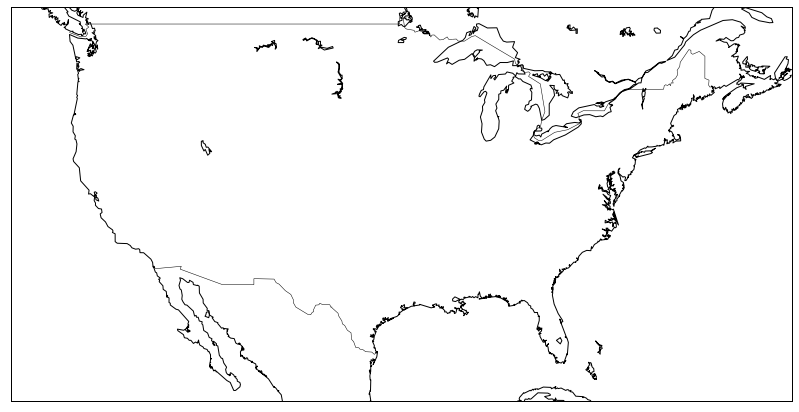

In [57]:
# For the map itself...
import os
os.environ["PROJ_LIB"] = "C:\\Users\\emmy1\\Anaconda3\\pkgs\\proj4-5.2.0-ha925a31_1\\Library\\share"; #fixr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# rcParms allows setting size of the figure
from pylab import rcParams
%matplotlib inline

# We set size of the figure
rcParams['figure.figsize'] = (14,10)

# Set parameters for plotting the map
my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130,
                 llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
                urcrnrlon=-60,
                 urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

# Add features we want to show in the map...
my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# This line is to creat a colored map
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

# This set of instructions is used to genarate scatter plot in the map
countrange=max(df_airports['conFlight'])-min(df_airports['conFlight'])
# The following array normalizes the values in the 'delay' df_airports dataframe
# (assigns zscore to them) and determins its likelihood to be delayed by means
# of the sigmoid function.
al=np.array([sigmoid(x) for x in zscore(df_airports['delay'])])
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
val=df_airports['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,
               color=colors[(al*20).astype(int)])

# Set of instructions to add text
df_text=df_airports[(df_airports['conFlight']>60000) &
                    (df_airports['IATA'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['IATA'])
zp=zip(xt,yt,txt)

for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()

### Explorating route delays

We now will explore routes that are typically the most delayed.

In [53]:
# We select, from out SQLContext, fields that are of our interest to get 
# the routes that are the most delayed...
grp_rout_Delay = sqlContext.sql("SELECT Origin, Dest, count(*) traffic,avg(Distance) avgDist,\
                                    avg(DepDelay) avgDelay\
                                FROM airlineDF \
                                GROUP BY Origin,Dest")
# ... and turn it into a pandas dataframe
rout_Delay = grp_rout_Delay.toPandas()

In [58]:
rout_Delay.head()

,Origin,Dest,traffic,avgDist,avgDelay
0,LAS,LIT,382,1295.0,7.450262
1,PHL,MCO,6939,861.0,12.534371
2,SMF,BUR,3406,358.0,6.851145
3,SNA,PHX,5412,338.0,4.884701
4,MCI,IAH,2481,643.0,4.110842


In [59]:
# We recall what the the dataframe df_aux looked like..
df_aux.head()

,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
name,,,,,,,,,,


In [60]:
# We merge the previously shown dataframes to get our dataframe of interest
df_airport_rout1 = pd.merge(rout_Delay, df_aux, left_on = 'Origin', right_on = 'IATA')

In [61]:
df_airport_rout1.head()

,Origin,Dest,traffic,avgDist,avgDelay,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz


In [62]:
df_airport_rout1.head()

,Origin,Dest,traffic,avgDist,avgDelay,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz


In [81]:
df_aux.head()

,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
2,Madang,Madang,Papua New Guinea,MAG,AYMD,-5.207083,145.788700,20,10.0,U,Pacific/Port_Moresby
3,Mount Hagen,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789,144.295861,5388,10.0,U,Pacific/Port_Moresby
4,Nadzab,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569828,146.726242,239,10.0,U,Pacific/Port_Moresby
5,Port Moresby Jacksons Intl,Port Moresby,Papua New Guinea,POM,AYPY,-9.443383,147.220050,146,10.0,U,Pacific/Port_Moresby
6,Wewak Intl,Wewak,Papua New Guinea,WWK,AYWK,-3.583828,143.669186,19,10.0,U,Pacific/Port_Moresby


In [63]:
# We merge the previously shown dataframes to get our dataframe of interest
df_airport_rout2 = pd.merge(df_airport_rout1, df_aux, left_on = 'Dest', right_on = 'IATA')


In [64]:
df_airport_rout2.head()

,Origin,Dest,traffic,avgDist,avgDelay,city_x,country_x,IATA_x,ICAO_x,lat_x,...,city_y,country_y,IATA_y,ICAO_y,lat_y,lng_y,alt_y,TZone_y,DST_y,Tz_y


In [67]:
df_airport_rout = df_airport_rout2[["Origin","lat_x","lng_x","Dest","lat_y","lng_y",\
                                    "avgDelay", "traffic"]]

In [68]:
df_airport_rout.head()

,Origin,lat_x,lng_x,Dest,lat_y,lng_y,avgDelay,traffic


We now generate a similar map as before but this time showing routes

C:\Users\emmy1\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\emmy1\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\emmy1\Anaconda3\lib\site-packages\scipy\stats\stats.py:2416: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis, keepdims=True)
C:\Users\emmy1\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\emmy1\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\emmy1\Anaconda3\lib\site-packages\num

NameError: name 'zp' is not defined

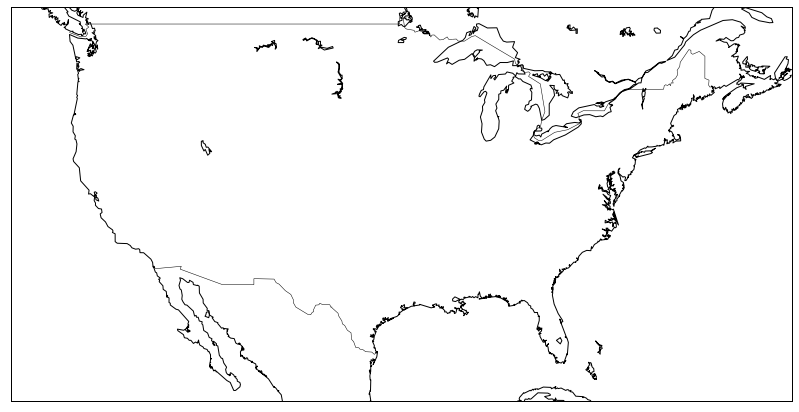

In [98]:
from scipy.stats import zscore
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

delay=np.array([sigmoid(x) for x in zscore(df_airports["delay"])])
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 40))
colors=np.flipud(colors)
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
xo,yo = my_map(np.asarray(df_airport_rout['lng_x']), np.asarray(df_airport_rout['lat_x']))
xd,yd = my_map(np.asarray(df_airport_rout['lng_y']), np.asarray(df_airport_rout['lat_y']))

my_map.scatter(xs, ys,  marker='o',  alpha = 0.8,color=colors[(delay*20).astype(int)])


al=np.array([sigmoid(x) for x in zscore(df_airport_rout["avgDelay"])])
f=zip(xo,yo,xd,yd,df_airport_rout['avgDelay'],al)
for row in f:
    plt.plot([row[0],row[2]], [row[1],row[3]],'-',alpha=0.07, \
             color=colors[(row[5]*30).astype(int)] )
    

for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each line represents a route from the Origin to Destination airport.")
print("The redder line, the higher probablity of delay.")
    
plt.show()



### Exploring airport origin delay per month

We set the airport code name we want to explore, say **JFK**

In [70]:
Origin_Airport="JFK"

In [71]:
df_ORG = sqlContext.sql("SELECT * from airlineDF WHERE origin='"+ Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")
df_ORG.select('ArrTime','CRSArrTime','CRSDepTime',\
              'DayOfWeek','DayofMonth','DepDelay','DepTime','Dest').show(2)

+-------+----------+----------+---------+----------+--------+-------+----+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|
+-------+----------+----------+---------+----------+--------+-------+----+
|   1815|      1803|      1559|        2|         1|      -9|   1550| CLT|
|    850|       822|       620|        2|         1|       0|    620| CLT|
+-------+----------+----------+---------+----------+--------+-------+----+
only showing top 2 rows



Let's look at the number of flights originating from this airport:

In [73]:
print ("total flights from this ariport: " + str(df_ORG.count()))

total flights from this ariport: 115367


We now group flights by month to see how delayed flights are distributed by month:

In [74]:
grp_carr = sqlContext.sql("SELECT  UniqueCarrier,month, avg(DepDelay) avgDelay from df_ORG \
                            WHERE DepDelayed=True \
                            GROUP BY UniqueCarrier,month")
s = grp_carr.toPandas()

In [75]:
s.head()

,UniqueCarrier,month,avgDelay
0,B6,2,65.122346
1,UA,9,74.808511
2,MQ,8,80.391026
3,B6,9,64.213084
4,US,12,57.763636


In [76]:
ps = s.pivot(index='month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]

In [77]:
ps.head()

UniqueCarrier,AA,UA,US
month,,,
1,63.132743,70.833333,47.523810
2,75.965385,80.731707,59.351351
3,76.185606,63.142857,73.607143
4,85.349020,99.142857,70.800000
5,79.316239,61.440000,42.933333


Text(0.5, 1.0, 'Carrier delay in each month')

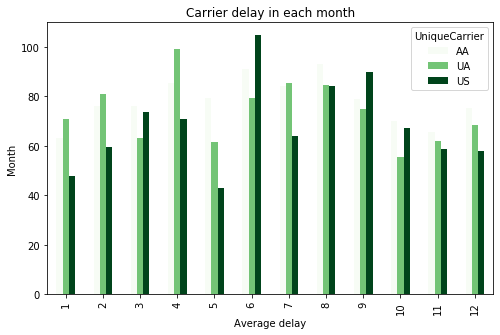

In [78]:
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Greens');
plt.xlabel('Average delay')
plt.ylabel('Month')
plt.title('Carrier delay in each month')

### Exploring airport origin delay per day/hour

In [79]:
hour_grouped = df_ORG.filter(df_ORG['DepDelayed']).select('DayOfWeek','hour',
                                                          'DepDelay').groupby('DayOfWeek',
                                                                              'hour').mean('DepDelay')

In [80]:
hour_grouped.take(3)

[Row(DayOfWeek=6, hour=13, avg(DepDelay)=61.136842105263156),
 Row(DayOfWeek=1, hour=12, avg(DepDelay)=65.87837837837837),
 Row(DayOfWeek=5, hour=19, avg(DepDelay)=74.78301886792453)]

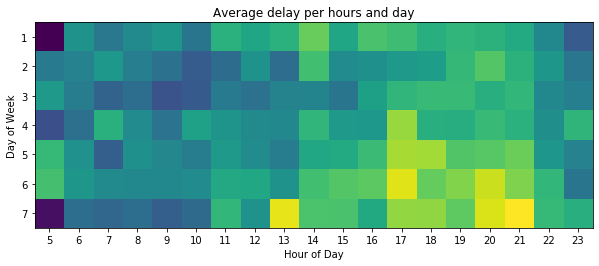

In [81]:
rcParams['figure.figsize'] = (10,5)
dh = hour_grouped.toPandas()
c = dh.pivot('DayOfWeek','hour')
X = c.columns.levels[1].values
Y = c.index.values
Z = c.values
plt.xticks(range(0,24), X)
plt.yticks(range(0,7), Y)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours and day')
plt.imshow(Z)

A clear pattern here: flights tend to be delayed in these situations:  
- Later in the day: possibly because delays tend to pile up as the day progresses and the problem tends to compound later in the day.  
- Mornings in first day of week possibly because of more business meetings

## Modeling: Logistic Regression
In this section, we will build a supervised learning model to predict flight delays for flights leaving our selected airport.


### Preprocessing: Feature selection
In the next two cell we select the features that we need to create the model.

In [95]:
df_model=df_ORG
#stringIndexer1 = StringIndexer(inputCol="Origin", outputCol="originIndex")
#model_stringIndexer = stringIndexer1.fit(df_model)
#indexedOrigin = model_stringIndexer.transform(df_model)
#encoder1 = OneHotEncoder(dropLast=False, inputCol="originIndex", outputCol="originVec")
#df_model = encoder1.transform(indexedOrigin)

AttributeError: 'OneHotEncoder' object has no attribute 'transform'

In [96]:
stringIndexer2 = StringIndexer(inputCol="Dest", outputCol="destIndex")
model_stringIndexer = stringIndexer2.fit(df_model)
indexedDest = model_stringIndexer.transform(df_model)
encoder2 = OneHotEncoder(dropLast=False, inputCol="destIndex", outputCol="destVec")
ohe = encoder2.fit(df_model)
df_model = ohe.transform(indexedDest)








IllegalArgumentException: destIndex does not exist. Available: Year, Month, DayofMonth, DayOfWeek, DepTime, CRSDepTime, ArrTime, CRSArrTime, UniqueCarrier, DepDelay, Origin, Dest, Distance, DepDelayed, Hour

We use __labeled point__ to make local vectors associated with a label/response. In MLlib, labeled points are used in supervised learning algorithms and they are stored as doubles. For binary classification, a label should be either 0 (negative) or 1 (positive). 

In [97]:
assembler = VectorAssembler(
    inputCols = ['Year','Month','DayofMonth','DayOfWeek','Hour','Distance','destVec'],
    outputCol = "features")
output = assembler.transform(df_model)
airlineRDD=output.map(lambda row: LabeledPoint([0,1][row['DepDelayed']],row['features']))

IllegalArgumentException: destVec does not exist. Available: Year, Month, DayofMonth, DayOfWeek, DepTime, CRSDepTime, ArrTime, CRSArrTime, UniqueCarrier, DepDelay, Origin, Dest, Distance, DepDelayed, Hour

### Preprocessing: Spliting dataset into train and test dtasets

In [91]:
trainRDD,testRDD=airlineRDD.randomSplit([0.7,0.3])
#print str(trainRDD.count()) +"  "+ str(testRDD.count())

NameError: name 'airlineRDD' is not defined

In [88]:
testRDD.take(2)

NameError: name 'testRDD' is not defined

### Build the model

In [108]:
model = LogisticRegressionWithLBFGS.train(trainRDD)

## Model Evaluation

In [109]:
# Evaluating the model on testing data
labelsAndPreds = testRDD.map(lambda p: (p.label, model.predict(p.features)))

In [110]:
def conf(r):
    if r[0] == r[1] ==1: x= 'TP'
    if r[0] == r[1] ==0: x= 'TN'
    if r[0] == 1 and  r[1] ==0: x= 'FN'
    if r[0] == 0 and  r[1] ==1: x= 'FP'
    return (x)
acc1 = labelsAndPreds.map(lambda (v, p): ((v, p),1)).reduceByKey(lambda a, b: a + b).take(5)
acc = [(conf(x[0]),x[1]) for x in acc1]

In [112]:
TP=TN=FP=FN=0.0
for x in acc: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
eps = sys.float_info.epsilon
Accuracy = (TP+TN) / (TP + TN+ FP+FN+eps) 
print "Model Accuracy for JFK: %1.2f %%" % (Accuracy*100)

Model Accuracy for JFK: 72.91 %


### Use the model to predict your flight from JFK

You can use the following widget to query the model.  
For example the following flight has dely:  
    Month=2, Day=3, Hour=18, Dest=CLE

In [114]:
Destin = rout_Delay[rout_Delay['Origin']=='JFK'].Dest.unique()

@interact(Destination=tuple(Destin),Month=(1,12),DayOfWeek=(0,7),Hour=(0,23))
def g(Destination,Month,DayOfWeek,Hour):
    Distance=int(rout_Delay[(rout_Delay['Origin']=='JFK') & (rout_Delay['Dest']==Destination)]\
                 .avgDist.tolist()[0])
    testcase=Row(Year=2007.0,Month=Month,DayofMonth=2.0,DayOfWeek=DayOfWeek,Hour=Hour,\
                 Origin='JFK',\
          Dest=Destination,Distance=Distance) 
    TestCase_df = sqlContext.createDataFrame(sc.parallelize([testcase]))
    t1= model_stringIndexer.transform(TestCase_df)
    t2=encoder2.transform(t1)
    p=model.predict(assembler.transform(t2).take(1)[0]['features'])
    print "Flight from JFK to "+Destination + ", Distance:" + str(Distance)
    if p==0:
        print "You flight doesnt have a delay, Accuracy= %1.2f %%" % (Accuracy*100)
    else:
        print "You flight may be delayed, Accuracy= %1.2f %%" % (Accuracy*100)


Flight from JFK to OAK, Distance:2576
You flight doesnt have a delay, Accuracy= 72.91 %
